## Clustering Model for Plant Maintenance Transactions in SAP
######  Master of Science in Data Science | University of Colorado Boulder
###### Name: BIN LIN /Student ID: 110342931

At my workplace, we use the SAP Plant Maintenance module to track plant maintenance and repair work, along with its cost. Maintenance activities are executed through work orders that are used to plan, schedule, and execute activities on technical objects such as equipment, machines, or buildings.

A work order can be created for different types of maintenance activities, such as corrective, preventive, or predictive maintenance. It contains all the necessary information for maintenance technicians to carry out the required tasks, including detailed instructions, parts required, and labor costs. Work orders can also be used to record time spent on maintenance activities and track the progress of maintenance work.

Although most repair work is logged in our notification system with complete information, there are instances where immediate repairs are carried out without following proper procedures, leading to missing information in SAP due to a lack of personnel or rush of work.

Please refer to the following flowchart that briefly shows the SAP procedure of work orders:

![MR Chart](https://bn02pap001files.storage.live.com/y4mC82EVC8C5CBGBiB9wEuwAt8KKgBH9KbsvS8IZqR2NPjk25onEy9IDL-DGRkeMumXdRd0qR2R3q6u0oxYqCimwHWwXyX3JaTobtMYPvzUJ_aO_s8fECG0NG8cu-d5q6ADfU3vYUTqD36TmqKFq0p4T_pkVaorM5yzq9v0u0jnH4opPMRGBcAj_xZUJWu3fvFEakgN6TumbDpOajW4Z7dLFw?encodeFailures=1&width=1161&height=288 "PM Chart")

In SAP PM, each production area is mapped to a field called Function Location, while equipment is mapped to Equipment. However, immediate work orders often lack accurate Function Location information or have mislabeled fields. To overcome this, we can use information from the text field in the work order, which briefly explains the work done and the MRO parts used.

##### The absence of Function Location information makes it difficult to determine the cost spent in each function area and the frequency of breakdowns. Therefore, the goal of this project is to use unsupervised machine learning technology, specifically clustering, to help label work orders with accurate Function Location information.

In the end, the result of the clustering can identify patterns and trends in plant maintenance work orders, such as the most common types of maintenance work or the most frequently occurring breakdowns in different functional locations. It may also be useful for predicting maintenance costs or optimizing maintenance schedules.

In [114]:
#Import all required python modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pandas_profiling as pp
import string
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression


### Data Extract Process and EDA

To develop the clustering ML model, we need to extract the raw dataset from the SAP PM database. Here's the data extract process we followed:

1. We requested the SAP Business Analyst to expose the SAP PM related tables to our data warehouse team.
2. Our Data Engineers then constructed a schema of PM datasets in the data warehouse for us to query.
3. We used SQL queries to extract the last three years of PM data into a CSV file.

![MR Chart](https://bn02pap001files.storage.live.com/y4mVyy6FECucOM8APSnEfbF5ZHAenOSzURBaEBKOTGe1lQt72yjuRmuKFtjyWNjAHyp0qZM0AB-v_pVIxImkrcqmaNoLwCYsQDhBT3QYxG88AK10c6d9RYZZVryP_0uLe_B8Xsz-vxcKAG_EIW5-rqcEZGyMSPQ4ZoC-7agpTQO61eVqsQ7yhSADZG6vGVQiqJeaPMedngMmnVzp5wF3qHYLQ?encodeFailures=1&width=1012&height=613 "SQL Code")

For first step- clustering modeling, which it only requires the work order number, Document number and IO_ description, ItemText and function location. so the other fields are temporaly dropped from the data frame.

1. DocumentNumber: A unique identifier for the plant maintenance work order.
2. OrderNumber: An identifier for the order associated with the work order.
3. IO_Description: A description of the maintenance work to be performed.
4. ItemText: Additional information related to the maintenance work, such as parts required.
5. FunctionalLocation: A field used in SAP PM to map each production area or piece of equipment to a location or function.

In [50]:
# Load Maintenance Data-MR_Data.csv
data = pd.read_csv(r'C:\Users\ilin\OneDrive\Documents\Data Science\CU Boulder MSDS\5510 Unsupervised Algorithms in Machine Learning\MR_Data.csv')
# data.describe()
#Drop off fields that are not needed for clustering
data=data.drop(["Vendor ID","Vendor","Vendor Name","GLAccount","Vendor Name.1","EquipmentNumber"
                ,"EquipmentNumberDesc","FunctionalLocationDesc"], axis=1)
data["FunctionalLocation"] = data["FunctionalLocation"].str[5:7]
# data = data.replace(np.nan, '')
data.head()

,DocumentNumber,OrderNumber,IO_Description,ItemText,FunctionalLocation
0,4901455672,14073851.0,REPLACE CATCH MAGNETIC GUARD ON STANDARD,NaN,56
1,4901472904,14075619.0,REPLACE VALVES/CONDUIT ON FILLER C3,NaN,35
2,4901242023,14052699.0,REPLACE GLUE FILTERS ON FUTURA LABELER L,NaN,55
3,4901467369,14074936.0,Filler A1 need format change to 7915,NaN,35
4,5000423570,420020.0,Depalletizer MT Can Conveyors - M & R,"1346K49 Rotary Shaft 1-1/4 X 72""""",NaN


In [51]:
# Find the unique values in the "FunctionalLocation" column
unique_locations = data["FunctionalLocation"].unique()

# Display the unique values
print(unique_locations)

['56' '35' '55' nan '05' '65' '45' '50' '' '75' '60' '30' '80' '70' '77'
 '73' '57' '72' '79' '01' '15' '85' '81']


Function Location are 2 digits numbers in SAP. The description can be applied after the analysis work. Based on the unique locations list, we can see there are 'nan','' in the function location, which need to be cleaned up

In [78]:
# Split the data into train and test datasets based on the "FunctionalLocation" column
data_trim=data.drop(["OrderNumber"], axis=1)
data_trim["Description"] = data_trim["IO_Description"] + " " + data_trim["ItemText"].astype(str)
data_trim["Description"] = data_trim["Description"].str.replace("nan", "")
data_trim["Description"] = data_trim["Description"].str.replace('"', "")
test_indices = np.where((data_trim["FunctionalLocation"].isnull()) | (data_trim["FunctionalLocation"] == ""))[0]
data_trim=data_trim.drop(["IO_Description","ItemText"], axis=1)

# train= data_trim[data_trim["FunctionalLocation"].notnull()]
# test= data_trim[data_trim["FunctionalLocation"].isnull()]
train= data_trim.drop(test_indices)
test= data_trim.iloc[test_indices]
train = train.replace(np.nan, '')

# Display the train and test datasets
print(train.head())
print(test.head())


   DocumentNumber FunctionalLocation  \
0      4901455672                 56   
1      4901472904                 35   
2      4901242023                 55   
3      4901467369                 35   
5      4901243452                 05   

                                 Description  
0  REPLACE CATCH MAGNETIC GUARD ON STANDARD   
1       REPLACE VALVES/CONDUIT ON FILLER C3   
2  REPLACE GLUE FILTERS ON FUTURA LABELER L   
3      Filler A1 need format change to 7915   
5                  exhaust fans not running   
    DocumentNumber FunctionalLocation  \
4       5000423570                NaN   
9       5000432084                NaN   
11      5000324594                NaN   
15      5000513623                NaN   
18      5100179939                NaN   

                                          Description  
4   Depalletizer MT Can Conveyors - M & R 1346K49 ...  
9   Oilers, Convrs, Elevators Lowrator-M&R EXPEDIT...  
11                              Retorts - M & R LABOR  
15  SF

### Data Exploration

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ilin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


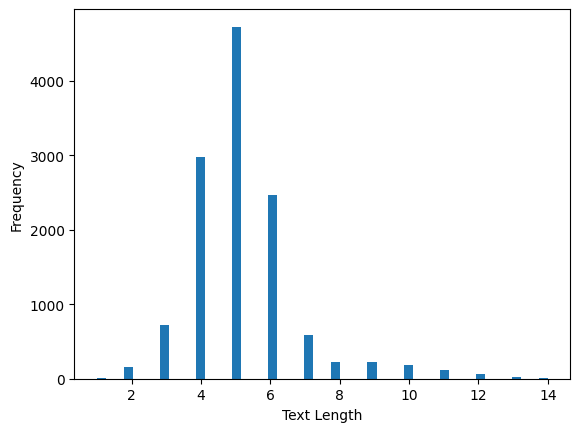

In [79]:
nltk.download("punkt")
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()

def prep_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [ps.stem(token) for token in tokens if token not in string.punctuation and token not in stop_words]
    return tokens

train["Description"] = train["Description"].apply(prep_text) 
train["TextLength"] = train["Description"].apply(lambda x: len(x))
plt.hist(train["TextLength"], bins=50)  
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

25 most common words: [('replac', 6597), ('line', 2842), ('pm', 2705), ('weekli', 1958), ('retort', 1680), ('filler', 1296), ('seamer', 1008), ('b', 889), ('label', 874), ('repair', 711), ('pump', 696), ('c', 691), ('sensor', 651), ('valv', 640), ('mechan', 627), ('gasket', 464), ('thaw', 449), ('switch', 439), ('1', 431), ('door', 416), ('system', 413), ('pallet', 403), ('chain', 398), ('belt', 385), ('see', 376)]


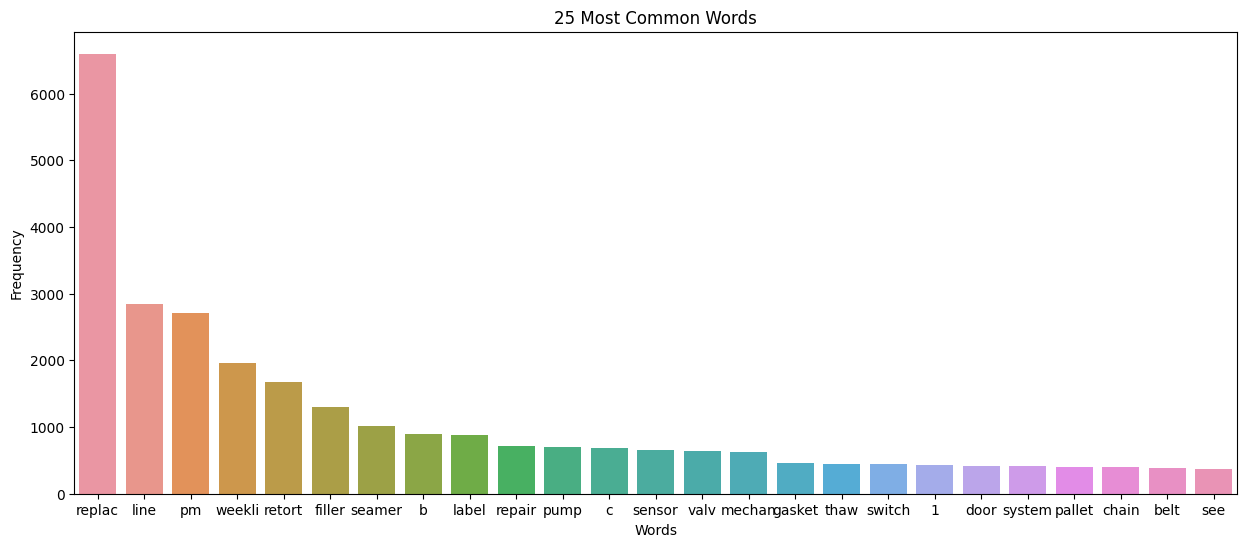

25 most common bigrams: [(('weekli', 'pm'), 1955), (('pm', 'replac'), 1117), (('line', 'b'), 646), (('mechan', 'weekli'), 581), (('line', 'c'), 393), (('see', 'attach'), 375), (('line', 'replac'), 362), (('attach', 'pm'), 360), (('pm', "'s"), 357), (('gasket', 'retort'), 344), (('monthli', 'pm'), 317), (('door', 'gasket'), 310), (('repair', 'made'), 309), (('replac', 'o-r'), 308), (('o-r', 'door'), 294), (('seamer', 'line'), 285), (('filler', 'line'), 281), (('standard', 'knapp'), 274), (('b', 'weekli'), 273), (('thaw', 'system'), 272), (('retort', '3'), 270), (('replac', 'sensor'), 255), (('elev', 'line'), 251), (('b', 'replac'), 249), (('c', 'replac'), 191)]


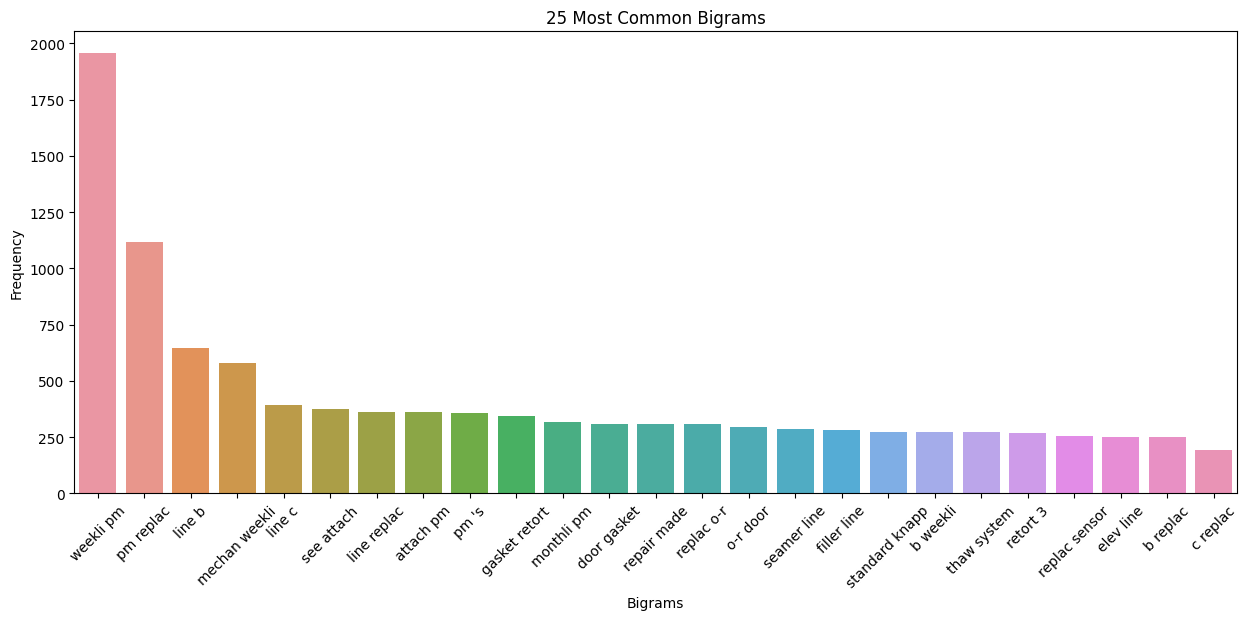

In [80]:
# Flatten the list of tokens for all documents
all_tokens = [token for doc in train["Description"] for token in doc]

# Calculate word frequencies
word_freqs = Counter(all_tokens)

# Display the 20 most common words
common_words = word_freqs.most_common(25)
print("25 most common words:", common_words)

# Visualize the 20 most common words
plt.figure(figsize=(15, 6))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("25 Most Common Words")
plt.show()

# Calculate bigram frequencies
bigrams = ngrams(all_tokens, 2)
bigram_freqs = Counter(bigrams)

# Display the 25 most common bigrams
common_bigrams = bigram_freqs.most_common(25)
print("25 most common bigrams:", common_bigrams)

# Visualize the 25 most common bigrams
plt.figure(figsize=(15, 6))
sns.barplot(x=[f"{bigram[0][0]} {bigram[0][1]}" for bigram in common_bigrams], y=[bigram[1] for bigram in common_bigrams])
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("25 Most Common Bigrams")
plt.xticks(rotation=45)
plt.show()

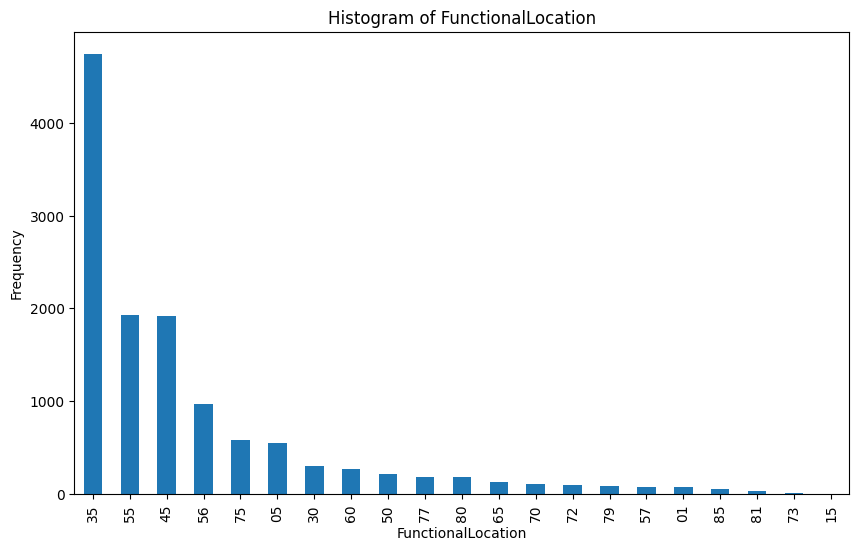

In [81]:
plt.figure(figsize=(10, 6))
train['FunctionalLocation'].value_counts().plot(kind='bar')
plt.xlabel("FunctionalLocation")
plt.ylabel("Frequency")
plt.title("Histogram of FunctionalLocation")
plt.show()

Non-negative Matrix Factorization (NMF) is a machine learning technique that factorizes a matrix into two non-negative matrices. It is often used for topic modeling and text mining. The TfidfVectorizer is a feature extraction method that transforms text into a matrix of TF-IDF features.

To perform NMF using TfidfVectorizer, we first need to preprocess the text data by removing stop words, converting text to lowercase, and tokenizing the text. Then we can use TfidfVectorizer to transform the text data into a matrix of TF-IDF features.

Next, we can apply NMF to factorize the TF-IDF matrix into two non-negative matrices, where one matrix represents the topics and the other matrix represents the weights of the topics for each document. We can then use the topics and weights to label the documents and identify similar documents based on their topic distributions.

In [82]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

In [83]:
join=[' '.join(words) for words in train["Description"]]
X = vectorizer.fit_transform(join)
# X = vectorizer.fit_transform(train['Text'])
print(X.shape)
DisplayX = X.toarray()
print(DisplayX[:5])

(12484, 2640)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [90]:
num_txt = 21
nmf = NMF(n_components=num_txt, random_state=42,max_iter=500)
nmf.fit(X)

# Assign topics to documents
train_txt_assignments = nmf.transform(X).argmax(axis=1)

# Map topics to categories
txt_to_label = {}
for txt in range(num_txt):
    txt_to_label[txt] = train.loc[train_txt_assignments == txt, 'FunctionalLocation'].mode()[0]

# Make predictions for the training set
train_predictions = [txt_to_label[txt] for txt in train_txt_assignments]

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(train['FunctionalLocation'], train_predictions)
conf_matrix = confusion_matrix(train['FunctionalLocation'], train_predictions)

print("Train accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix)

Train accuracy: 0.6024511374559436
Confusion matrix:
 [[   0    4    0    0   57   10    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0  297    0    0  243    4    0    2    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    5    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0   71    0    0  220    6    0    6    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0   53    0    0 4563    9    0   82    8    0    0    0    0    0
     0    0    0    0   28    0    0]
 [   0   61    0    0  645 1201    0    4    0    0    0    0    0    0
     0    0    0    0    9    0    0]
 [   0    0    0    0  161    0    0   20   39    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0   10    0    0  706    1    0 1115   63    0    0    0    0    0
     0    0    0    0   34    0    0]
 [   0    4    0    0  322    0    0  344  283    0    0    0    0

In [88]:
txt_to_label

{0: '45', 1: '45', 2: '35', 3: '35', 4: '35'}

After the first attempt above, the accuracy score is 0.60, not ideal.

To improve the performance of the NMF model, I need to test it with different numbers of components (texts). Below is another model runs the NMF model with varying numbers of components, and calculates the train accuracy, confusion matrix, and then plots the train accuracy against the number of components.

Hope to tune the NMF model and explore the relationship between the number of components and the train accuracy. As the number of components increases, the model has more capacity to capture the underlying structure of the data.

Num Texts: 15, Train accuracy: 0.5530278756808715
Num Texts: 17, Train accuracy: 0.5519064402435117
Num Texts: 19, Train accuracy: 0.5792214033963473
Num Texts: 21, Train accuracy: 0.6024511374559436
Num Texts: 31, Train accuracy: 0.5843479653957065
Num Texts: 41, Train accuracy: 0.6047741108619032
Num Texts: 51, Train accuracy: 0.6480294777314963
Num Texts: 55, Train accuracy: 0.6598045498237745
   num_txt  accuracy                                   confusion_matrix
0       15  0.553028  [[0, 3, 0, 0, 58, 10, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       17  0.551906  [[0, 4, 0, 0, 57, 10, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       19  0.579221  [[0, 4, 0, 0, 57, 10, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       21  0.602451  [[0, 4, 0, 0, 57, 10, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       31  0.584348  [[0, 1, 0, 0, 60, 10, 0, 0, 0, 0, 0, 0, 0, 0, ...
5       41  0.604774  [[0, 1, 0, 3, 24, 16, 0, 6, 0, 0, 0, 0, 0, 0, ...
6       51  0.648029  [[0, 1, 0, 1, 13, 10, 0, 14, 0, 0, 0, 0, 3, 0,...
7       55  0.659805  [[

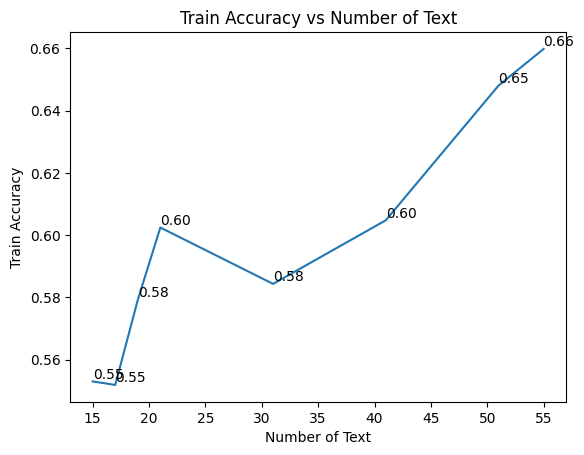

In [98]:
#change the num_topics hyperparameter for best accuracy
results = []
num_txt_list = [15,17,19,21,31,41,51,55]

for num_txt in num_txt_list:
    nmf = NMF(n_components=num_txt, random_state=42,max_iter=500)
    nmf.fit(X)

    train_txt_assignments = nmf.transform(X).argmax(axis=1)

    txt_to_label = {}
    for txt in range(num_txt):
        txt_to_label[txt] = train.loc[train_txt_assignments == txt, 'FunctionalLocation'].mode()[0]

    train_predictions = [txt_to_label[txt] for txt in train_txt_assignments]

    accuracy = accuracy_score(train['FunctionalLocation'], train_predictions)
    conf_matrix = confusion_matrix(train['FunctionalLocation'], train_predictions)

    print(f"Num Texts: {num_txt}, Train accuracy: {accuracy}")
    
    results.append((num_txt, accuracy, conf_matrix))

results_df = pd.DataFrame(results, columns=['num_txt', 'accuracy', 'confusion_matrix'])
print(results_df)
plt.plot(results_df['num_txt'], results_df['accuracy'])
plt.xlabel('Number of Text')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Number of Text')
for index, row in results_df.iterrows():
    plt.text(row['num_txt'], row['accuracy'], f"{row['accuracy']:.2f}", ha='left', va='bottom')
plt.show()

Based on these results, the train accuracy increases as the number of text increases, with the highest train accuracy (0.65980) achieved when the number of texts is set to 55. This indicates that the model performs better with more texts in this case, allowing it to capture more complex patterns and relationships in the data.
That raised me a concern about whether the data quality is good enough for NMF modeling. It might contains too much inconsistencies, noise, or missing values, where impact the model's ability to learn and make accurate predictions. 

Let's try a supervised machine learning- Classification method.

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(join, train['FunctionalLocation'], 
                                                    test_size=0.2, random_state=42)

# Create a pipeline for feature extraction and SVM classification
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear', C=1, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test accuracy: {accuracy}")
print(f"Confusion matrix:\n{conf_matrix}")

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated accuracy: {best_score}")

Test accuracy: 0.920704845814978
Confusion matrix:
[[ 10   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 108   0   1   0   0   0   0   0   0   0   0   0   0   2   0   0   0
    0   0]
 [  0   0  62   7   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   2 925   1   0   7   0   0   3   0   1   0   0   1   0   0   0
    0   0]
 [  0   1   0   6 373   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   5   0  27   4   0   0   1   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  33   0   2 342  22   1   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   1   0  10   0   1  43 145   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   6   0   0   0   0  12   0   0   0   0   0   0   0   0   0
    0   0]
 [  1   1   0   6   1   0   0   0   0  41   1   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   1   1   0   0   0   0   0  12   0   0   0   0   1   0   1
    0   0]
 [  0   0   0 

From the confusion matrix, we can see that the SVM model performs well in most of the classes, with high values on the diagonal and relatively low values on the off-diagonal elements. This indicates that the model can accurately classify the majority of instances in the dataset. However, there are still a few misclassifications, particularly for classes with a smaller number of instances, suggesting that the model might struggle with some of the less frequent categories.

Now I really start questioning myself why NMF is out performed by SVM. I think one of the reasons is the text in each work order is not consistent, which is hard for feature extraction and dimensionality reduction.

I would give one more attempt by using ML pipeline for ensemble learning model (SVM+NMF)

In [105]:
num_txt = 51  # This should be the winning value found previously
svm_C = 1
svm_kernel = 'linear'

# Create a pipeline for feature extraction, NMF transformation, and SVM classification
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(n_components=51, random_state=42, max_iter=500)),
    ('svm', SVC(kernel='linear', C=1, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test accuracy: {accuracy}")
print(f"Confusion matrix:\n{conf_matrix}")

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated accuracy: {best_score}")

Test accuracy: 0.6676011213456148
Confusion matrix:
[[  0   0   0   8   0   0   0   0   0   0   0   0   0   0   0   0   3   0
    0   0]
 [  0  54   0  57   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  72   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 939   0   0   0   0   0   0   0   0   0   0   1   0   0   0
    0   0]
 [  0   0   0  44 337   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  32   0   0   1   0   0   0   0   0   0   0   4   0   0   0
    0   0]
 [  0   0   0 188   0   0 212   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  99   0   0  61  40   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  18   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  50   0   0   0   0   0   0   0   0   0   0   1   0   0   0
    0   0]
 [  0   0   0  16   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0

### Conclusion:
<bold>The ensemble machine learning model above, which combines the Support Vector Machine and NMF Non-negative Matrix Factorization, achieved a test accuracy of 66.76%. In this ensemble model, NMF is used for feature extraction, and SVM is used for classification.

The test accuracy of 66.76% indicates that the ensemble model is less accurate than the standalone SVM model, which achieved a test accuracy of 92.07%. This difference in performance could be due to the fact that NMF might not be the most suitable method for feature extraction in this specific problem or the combination of both algorithms is not effectively leveraging the strengths of each method.

The best parameters for the SVM model in the ensemble are C=10 and kernel='rbf'. These parameters were determined through cross-validation, which helps to find the optimal hyperparameters that result in the best model performance. The best cross-validated accuracy for this ensemble model is 83.07%, which is higher than the test accuracy of 66.76%. The difference between the cross-validated accuracy and the test accuracy suggests that the model might be overfitting to the training data, leading to reduced performance on unseen data.

In conclusion, the ensemble model and the NMF model are not suitable for SAP work order clustering. I will suggest that our IT team develop a mobile app for rapid work order submission, allowing users to quickly input more work order information in the app. This data would then be automatically uploaded into SAP, streamlining the process.</bold>